# Experiment 2 - Methodology

## Approach 1: 1-year Rolling Window

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("1-year-rolling").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

# spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-04-14 13:44:13,760 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-04-14 13:44:14,871 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-04-14 13:44:14,871 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2024-04-14 13:44:

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

In [3]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari/Stock-Implosion-Prediction-FYP


## Extract Yearly Time Series

In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols, get_tabular_dataset_qf
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer


def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.25)
    # df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)

    
    return df



df = get_df(f'{main_dir}/data/imploded_stocks_price.csv', all_feats=True, imploded_only=False, prediction=False)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-04-14 13:44:44,376 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


{'ff_accr_exp': 0.24735519759341887, 'ff_assets_com_eq': 0.09066693555841253, 'ff_assets_eq': 0.0136462561025822, 'ff_assets_gr': 0.07086978076919845, 'ff_assets_oth_tot': 0.054038838051543185, 'ff_assets_per_emp': 0.15823438957372254, 'ff_bnfit_loss_rsrv_tcap': 0.9792701269673213, 'ff_bps_gr': 0.11114472257934407, 'ff_capex_5ygr': 0.32089709008713774, 'ff_capex_assets': 0.027603418286319292, 'ff_capex_fix_assets': 0.27038745620005544, 'ff_capex_ps_cf': 0.05854277479475997, 'ff_cash_curr_assets': 0.2473383918593024, 'ff_cash_div_cf': 0.02515818397237137, 'ff_cash_div_covg_ratio': 0.5837723831371264, 'ff_cash_roce': 0.1392355071550413, 'ff_cash_secs_deps': 0.9007957515104154, 'ff_cf_ps_gr': 0.17077146722461703, 'ff_cf_sales': 0.08607897014461334, 'ff_claims_net_prem': 0.9887653667431328, 'ff_cogs_sales': 0.24284285798314384, 'ff_com_eq_deps': 0.89766988496475, 'ff_com_eq_gr': 0.09803624996848925, 'ff_com_eq_tcap': 0.03679615484803415, 'ff_debt_com_eq': 0.09238112043829355, 'ff_debt_entr

In [5]:
# from CreateDataset import get_fund_data_yearly

# price_data = get_fund_data_yearly(df)
# price_data = price_data.toPandas()
# price_data.to_csv('price_data.csv')

price_data = pd.read_csv('price_data.csv')

#### Grab the price/market value data

In [6]:
price_data=price_data.sort_values(by=['fsym_id','date'])
price_data['year'] = pd.to_datetime(price_data['date']).dt.year
price_data.head()

,Unnamed: 0,fsym_id,date,adj_price,Market_Value,year
0,0,B00FG1-R,2014-12-31,0.015095,248.699729,2014
1,1,B00FG1-R,2014-12-31,0.015095,248.699729,2014
2,2,B00FG1-R,2014-12-31,0.015095,248.699729,2014
3,3,B00FG1-R,2014-12-31,0.015095,248.699729,2014
4,4,B00FG1-R,2015-12-31,0.028761,531.092072,2015


In [7]:
price_df = price_data.groupby(['fsym_id', 'year'], as_index=False).first()
price_df.head()

,fsym_id,year,Unnamed: 0,date,adj_price,Market_Value
0,B00FG1-R,2014,0,2014-12-31,0.015095,248.699729
1,B00FG1-R,2015,4,2015-12-31,0.028761,531.092072
2,B00FG1-R,2016,8,2016-12-30,0.061295,1584.046059
3,B00FG1-R,2017,12,2017-12-29,0.174531,7311.973549
4,B00FG1-R,2018,16,2018-12-31,0.439903,19948.260284


In [8]:
df = df.toPandas()
df.head()

/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,0.000000,NaN,0.0,NaN,NaN,NaN,0.006181,7.9,-0.000121,0
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,0.000000,-32.489870,0.0,NaN,NaN,NaN,0.014049,6.7,0.002644,0
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,0.294125,3.610653,0.0,-95.4447,NaN,NaN,0.006058,5.6,-0.003085,0
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,1.071870,19.546902,0.0,-11.9743,NaN,NaN,0.001821,5.0,-0.001076,0
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,0.710952,21.835781,0.0,-22.8867,NaN,NaN,0.010414,4.7,0.002525,0


In [9]:
df['year'] = pd.to_datetime(df['date']).dt.year
# price_data['year'] = pd.to_datetime(price_data['date']).dt.year
df = pd.merge(df, price_df[['fsym_id','year','adj_price', 'Market_Value']], on=['fsym_id', 'year'], how='left')

/tmp/ipykernel_2858425/397788427.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['year'] = pd.to_datetime(df['date']).dt.year


In [10]:
df.head(100)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,year,adj_price,Market_Value
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,NaN,NaN,NaN,0.006181,7.9,-0.000121,0,2012,NaN,NaN
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,NaN,NaN,NaN,0.014049,6.7,0.002644,0,2013,NaN,NaN
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,-95.4447,NaN,NaN,0.006058,5.6,-0.003085,0,2014,0.015095,248.699729
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,-11.9743,NaN,NaN,0.001821,5.0,-0.001076,0,2015,0.028761,531.092072
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,-22.8867,NaN,NaN,0.010414,4.7,0.002525,0,2016,0.061295,1584.046059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B0592Z-R,2013-12-31,8.324,1.619421,1.619421,-26.837465,1.024,1.558397,-25.581610,0.000000,...,-25.0722,-24.600,-24.635,0.014049,6.7,0.002644,0,2013,2.150000,134811.450000
96,B0592Z-R,2014-12-31,6.688,1.563547,1.563547,-35.430184,0.102,1.584850,-33.213295,0.000000,...,-41.5968,-23.391,-23.468,0.006058,5.6,-0.003085,0,2014,1.220000,76579.400000
97,B0592Z-R,2015-12-31,6.048,1.370986,1.370986,-36.896236,0.252,1.111222,-28.168578,0.787421,...,-16.4902,-13.774,-13.761,0.001821,5.0,-0.001076,0,2015,2.170000,136475.640000
98,B0592Z-R,2016-12-31,7.990,1.367399,1.367399,-19.058094,0.252,0.925143,-28.205349,0.046325,...,-26.1294,-22.718,-22.719,0.010414,4.7,0.002525,0,2016,1.260000,89609.940000


In [11]:
def apply_log_returns(group):
    group['log_return'] = np.log(group['adj_price'] / group['adj_price'].shift(1))
    group['log_mv_return'] = np.log(group['Market_Value'] / group['Market_Value'].shift(1))
    return group

df = df.sort_values(by=['fsym_id', 'date'])
df = df.groupby('fsym_id').apply(apply_log_returns).reset_index(drop=True)


/opt/jupyterhub/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2858425/2661831441.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('fsym_id').apply(apply_log_returns).reset_index(drop=True)


In [12]:
df.head()

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,year,adj_price,Market_Value,log_return,log_mv_return
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,NaN,0.006181,7.9,-0.000121,0,2012,NaN,NaN,NaN,NaN
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,NaN,0.014049,6.7,0.002644,0,2013,NaN,NaN,NaN,NaN
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,NaN,0.006058,5.6,-0.003085,0,2014,0.015095,248.699729,NaN,NaN
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,NaN,0.001821,5.0,-0.001076,0,2015,0.028761,531.092072,0.644663,0.758689
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,NaN,0.010414,4.7,0.002525,0,2016,0.061295,1584.046059,0.756694,1.092802


In [13]:
df.drop(['year', 'adj_price', 'Market_Value'] , inplace=True, axis=1)

In [14]:
# df=df.toPandas()
print(len(df[df['label']==1]))

667


##### The implosion number is 667, not 711, because not all the imploded stocks have fundamental data available

In [15]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,log_return,log_mv_return
152,B0CXCV-R,2015-12-31,0.892413,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,...,0.000,NaN,-9.097105,-9.109441,0.001821,5.0,-0.001076,0,NaN,NaN
153,B0CXCV-R,2016-12-31,2.091352,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,...,0.000,NaN,-9.708269,-9.709015,0.010414,4.7,0.002525,0,NaN,NaN
154,B0CXCV-R,2017-12-31,0.715220,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,...,0.000,NaN,-25.652213,-25.656703,0.017494,4.1,0.002107,0,NaN,NaN
155,B0CXCV-R,2018-12-31,0.660945,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,...,0.000,-43.4143,-67.356411,-67.359557,0.005728,3.9,0.000685,0,NaN,NaN
156,B0CXCV-R,2019-12-31,0.695000,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,...,0.000,-95.6397,-12.038000,-12.041000,0.009593,3.6,0.003154,0,-1.723937,-1.242311
157,B0CXCV-R,2020-12-31,1.060000,1.544423,1.427903,167.621980,0.041000,0.297342,82.302726,0.460218,...,0.039,-53.4781,-12.705000,-12.705000,0.017409,6.7,0.004685,1,-16.215971,0.664353


### IMPORTANT - Convert to Prediction Task by shifting label backwards for each stock

In [16]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

df = convert_to_prediction(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-04-14 13:46:45,850 WARN scheduler.TaskSetManager: Stage 20 contains a task of very large size (9239 KiB). The maximum recommended task size is 1000 KiB.
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [17]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,log_return,log_mv_return
58119,B0CXCV-R,2015-12-31,0.892413,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,...,0.0,NaN,-9.097105,-9.109441,0.001821,5.0,-0.001076,0,NaN,NaN
58118,B0CXCV-R,2016-12-31,2.091352,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,...,0.0,NaN,-9.708269,-9.709015,0.010414,4.7,0.002525,0,NaN,NaN
58117,B0CXCV-R,2017-12-31,0.715220,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,...,0.0,NaN,-25.652213,-25.656703,0.017494,4.1,0.002107,0,NaN,NaN
58116,B0CXCV-R,2018-12-31,0.660945,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,...,0.0,-43.4143,-67.356411,-67.359557,0.005728,3.9,0.000685,0,NaN,NaN
58115,B0CXCV-R,2019-12-31,0.695000,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,...,0.0,-95.6397,-12.038000,-12.041000,0.009593,3.6,0.003154,1,-1.723937,-1.242311


## Feature Selection

### Drop Highly Correlated Variables

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_when.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.8:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
               
df=correlation_matrix(df)

In [19]:
df.columns #features

Index(['fsym_id', 'date', 'ff_accr_exp', 'ff_assets_com_eq',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val',
       'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld',
       'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_for_assets_pct',
       'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund',
       'ff_intang_oth', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap',
       'ff_mkt_val_gr', 'ff_mkt_val_public', 'ff_net_inc_per_emp',
       'ff_net_mgn_gr', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg',
       'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_receiv_turn', 'ff_roic',
       'ff_shs_float', 'ff_tcap_assets', 'ff_xord', 'ff_eps_dil_aft_xord',
       'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth',
       'ff_commiss_inc_net', 

In [20]:
feats = df.drop(['fsym_id', 'date', 'label'], axis=1).columns.tolist()

In [21]:

# Assuming df is your DataFrame
null_values_per_column = df.isnull().sum()
total_rows = len(df)

print("Proportion of null values per column:")
for column, null_count in null_values_per_column.items():
    proportion_null = null_count / total_rows
    print(f"Column '{column}': {proportion_null:.2%}")


Proportion of null values per column:
Column 'fsym_id': 0.00%
Column 'date': 0.00%
Column 'ff_accr_exp': 25.87%
Column 'ff_assets_com_eq': 8.87%
Column 'ff_assets_per_emp': 16.30%
Column 'ff_bps_gr': 11.82%
Column 'ff_capex_assets': 2.87%
Column 'ff_cash_curr_assets': 25.87%
Column 'ff_cash_div_cf': 2.47%
Column 'ff_cash_roce': 14.20%
Column 'ff_cf_ps_gr': 17.19%
Column 'ff_cf_sales': 7.48%
Column 'ff_com_eq_tcap': 3.60%
Column 'ff_debt_entrpr_val': 15.68%
Column 'ff_dfd_tax_assets_lt': 0.00%
Column 'ff_dil_adj': 0.90%
Column 'ff_div_yld': 15.99%
Column 'ff_earn_yld': 15.84%
Column 'ff_ebit_oper_roa': 20.83%
Column 'ff_eff_int_rate': 21.95%
Column 'ff_emp_gr': 22.30%
Column 'ff_entrpr_val_sales': 19.17%
Column 'ff_eps_basic_gr': 19.27%
Column 'ff_for_assets_pct': 18.45%
Column 'ff_for_sales_pct': 11.69%
Column 'ff_gross_cf_debt': 17.94%
Column 'ff_inc_adj': 0.07%
Column 'ff_inc_sund': 0.05%
Column 'ff_intang_oth': 22.50%
Column 'ff_invest_st_tot': 20.64%
Column 'ff_ltd_tcap': 3.83%
Col

### Drop columns with low variance

In [22]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label', 'date' ], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label', 'date'], axis=1).columns[mask]
print(remaining_feats)

Index(['ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_per_emp', 'ff_bps_gr',
       'ff_capex_assets', 'ff_cash_curr_assets', 'ff_cash_div_cf',
       'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap',
       'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj',
       'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate',
       'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr',
       'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt',
       'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth', 'ff_invest_st_tot',
       'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public',
       'ff_net_inc_per_emp', 'ff_net_mgn_gr', 'ff_non_oper_exp',
       'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf',
       'ff_receiv_turn', 'ff_roic', 'ff_shs_float', 'ff_tcap_assets',
       'ff_xord', 'ff_eps_dil_aft_xord', 'ff_std_debt', 'ff_tang_assets_debt',
       'ff_bk_oper_inc_oth', 'ff_commiss_inc_net', 'ff_cf_roic',
       'ff_l

In [23]:
df = df[remaining_feats.tolist()+['fsym_id', 'label', 'date']]

In [24]:
rows_with_null_count = df.isnull().any(axis=1).sum()

print(rows_with_null_count)

86384


In [25]:
print(len(df))

103643


In [26]:
split_date = '2020-01-01'
df=df.reset_index()
df['date'] = pd.to_datetime(df['date'])
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

In [27]:
print(len(train_df)/(len(df)))
print(len(test_df)/len(df))

0.8765087849637698
0.12349121503623013


In [28]:
print(len(train_df[train_df['label']==1]))
print(len(test_df[test_df['label']==1]))

499
127


### Imputation
The training and tests sets are handled slightly differently. Since the test set reflects our true, real-life simulation, we should not remove any 
rows to maintain a realistic distribution of implosions. However, for training we can be more flexible, since its sole purpose is to ensure 
the model can perform best on the test set.

In [29]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

# train_df = train_df.reset_index()
# test_df = test_df.reset_index()
feats = train_df.drop(['fsym_id', 'label', 'date'], axis=1).columns.tolist()

test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df[feats] = test_df.groupby(['year'])[feats].fillna(test_df.median())

train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year




In [30]:
mask = (train_df['label'] == 0) & (train_df.isnull().any(axis=1)) #remove the null values with majority class only - this is fine to do for the training set, but not the test set

train_df = train_df[~mask]

In [31]:
null_rows = test_df[test_df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

Empty DataFrame
Columns: [index, ff_accr_exp, ff_assets_com_eq, ff_assets_per_emp, ff_bps_gr, ff_capex_assets, ff_cash_curr_assets, ff_cash_div_cf, ff_cash_roce, ff_cf_ps_gr, ff_cf_sales, ff_com_eq_tcap, ff_debt_entrpr_val, ff_dfd_tax_assets_lt, ff_dil_adj, ff_div_yld, ff_earn_yld, ff_ebit_oper_roa, ff_eff_int_rate, ff_emp_gr, ff_entrpr_val_sales, ff_eps_basic_gr, ff_for_assets_pct, ff_for_sales_pct, ff_gross_cf_debt, ff_inc_adj, ff_inc_sund, ff_intang_oth, ff_invest_st_tot, ff_ltd_tcap, ff_min_int_tcap, ff_mkt_val_gr, ff_mkt_val_public, ff_net_inc_per_emp, ff_net_mgn_gr, ff_non_oper_exp, ff_oper_cf_fix_chrg, ff_oper_inc_tcap, ff_oper_ps_net_cf, ff_receiv_turn, ff_roic, ff_shs_float, ff_tcap_assets, ff_xord, ff_eps_dil_aft_xord, ff_std_debt, ff_tang_assets_debt, ff_bk_oper_inc_oth, ff_commiss_inc_net, ff_cf_roic, ff_liabs_lease, ff_compr_inc, Unemployment_Rate, log_return, log_mv_return, fsym_id, label, date, year]
Index: []

[0 rows x 59 columns]


In [32]:
# null_rows = train_df[train_df.isnull().any(axis=1)]

# print(null_rows)

In [33]:
train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.loc[train_df['label'] == 1].median())) #impute the stocks that do implode as we dont want to drop these even if they have null values due to their rarity

In [34]:
train_df=train_df.dropna()

In [35]:
exclude_columns = ['fsym_id', 'label', 'year', 'date']
feats = train_df.drop(exclude_columns, axis=1).columns.tolist()
print(feats)

['index', 'ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_receiv_turn', 'ff_roic', 'ff_shs_float', 'ff_tcap_assets', 'ff_xord', 'ff_eps_dil_aft_xord', 'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_commiss_inc_net', 'ff_cf_roic', 'ff_liabs_lease', 'ff_compr_inc', 'Unemployment_Rate', 'log_return', 'log_mv_return']


In [36]:
print(len(train_df.columns))
print(len(train_df['fsym_id']))
print(len(test_df['fsym_id']))
print(len(test_df[test_df['label']==1]))
print(len(train_df[train_df['label']==1]))

59
49997
12799
127
434


In [38]:
print(len(test_df)/(len(test_df)+len(train_df)))

0.20381871456780687


### Testing whether lags work
It was found that lags don't work very well due to too many null values - more suitable for a monthly frequency

In [ ]:
# print(feats)
# def create_lags(group):
#     # for col in feats:
#     #     group[f'{col}_lag1'] = group[col].shift(1).fillna(method='bfill')
#     #     # group[f'{col}_lag2'] = group[col].shift(2).fillna(method='bfill')
#     # return group
#     num_rows = len(group)
#     for col in feats:
#         if num_rows == 1:  # If only one row in the group, set lagged feature to original value
#             group[f'{col}_lag1'] = group[col]
#             # group[f'{col}_lag2'] = group[col]
#         else:
#             group[f'{col}_lag1'] = group[col].shift(1).fillna(method='bfill')
#             # group[f'{col}_lag2'] = group[col].shift(2).fillna(method='bfill')
#     return group

# train_df = train_df.sort_values(by=['fsym_id', 'date'])
# test_df = test_df.sort_values(by=['fsym_id', 'date'])
# train_df2 = train_df.groupby('fsym_id').apply(create_lags).reset_index(drop=True)
# test_df2 = test_df.groupby('fsym_id').apply(create_lags).reset_index(drop=True)

In [39]:
feats = train_df.drop(['date', 'fsym_id', 'label'], axis=1).columns.tolist()

### Testing differencing

In [ ]:
# def apply_diff(group):
#     group[f'return'] =group['adj_price'].diff().fillna(method='bfill')
#     group[f'mv_return'] =group['Market_Value'].diff().fillna(method='bfill')
#     return group

# train_df = train_df.sort_values(by=['fsym_id', 'date'])
# test_df = test_df.sort_values(by=['fsym_id', 'date'])
# train_df3 = train_df.groupby('fsym_id').apply(apply_diff).reset_index(drop=True)
# test_df3 = test_df.groupby('fsym_id').apply(apply_diff).reset_index(drop=True)

#### Add Industry Feature

In [42]:
print(len(train_df))
print(len(test_df))

49997
12799


In [59]:
def add_industry(df):

    temp_spark_df = spark.createDataFrame(df)
    temp_spark_df.createOrReplaceTempView('temp_table')

    q = """SELECT sc.fsym_id, e.factset_industry_desc FROM temp_table t
        LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
        LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
        LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
        LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code"""
    ind_df = spark.sql(q)
    ind_df = ind_df.toPandas()
    ind_df=ind_df.drop_duplicates(subset=['fsym_id'])
    df_with_industry = pd.merge(df, ind_df, on='fsym_id', how='left')
    one_hot_encoded = pd.get_dummies(df_with_industry['factset_industry_desc'])
    grouped_industry = df_with_industry.groupby('factset_industry_desc').size().sort_values(ascending=False)
    top_10 = grouped_industry.head(10).index.tolist()
    for col in one_hot_encoded.columns.tolist():
        if col not in top_10:
            one_hot_encoded.drop(col, axis=1, inplace=True)
    df_with_industry = pd.concat([df_with_industry, one_hot_encoded], axis=1)
    df_with_industry.drop('factset_industry_desc', axis=1, inplace=True)
    return df_with_industry

    
train_df = add_industry(train_df)
test_df = add_industry(test_df)

2024-04-14 14:26:00,662 WARN scheduler.TaskSetManager: Stage 40 contains a task of very large size (2057 KiB). The maximum recommended task size is 1000 KiB.


In [60]:
common_columns = train_df.columns.intersection(test_df.columns)

# Set both DataFrames to have only common columns
train_df = train_df[common_columns]
test_df = test_df[common_columns]

In [61]:
print(len(train_df))
print(len(test_df))

49997
12799


In [62]:
print(train_df.columns==test_df.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [ ]:
# import os
# import pandas as pd

# train_file = 'data_when/train_df_when.csv'
# test_file = 'data_when/test_df_when.csv'

# # Check if the files exist
# if not (os.path.exists(train_file) and os.path.exists(test_file)):
#     # Write DataFrames to files
#     train_df.to_csv(train_file, index=False)
#     test_df.to_csv(test_file, index=False)
# else:
#     # Read DataFrames from existing files
#     print("works")
#     train_df = pd.read_csv(train_file, index_col=False)
#     test_df = pd.read_csv(test_file, index_col=False)

In [70]:
train_df.head()

,ff_accr_exp,ff_assets_com_eq,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,ff_cf_ps_gr,ff_cf_sales,...,log_mv_return,fsym_id,label,date,year,Biotechnology,Medical Specialties,Miscellaneous Commercial Services,Packaged Software,Pharmaceuticals: Major
14884,4.035215,1.366157,0.117273,-0.034006,2.148558,33.099067,34.984328,6.057222,54.677865,4.447827,...,0.960800,XQ6LJ0-R,0,2000-01-31,2000,0,0,0,0,0
34027,389.953000,2.733014,0.054461,4.659683,12.656485,33.537477,0.000000,42.276467,126.747501,3.654636,...,0.943684,WPKF66-R,0,2000-01-31,2000,0,0,0,0,0
12575,157.171000,1.901156,0.284111,-16.714633,7.154709,66.156656,0.000000,37.279712,-31.788127,23.358901,...,-1.465654,D41CTF-R,0,2000-01-31,2000,0,0,0,0,0
46876,7.231000,2.682862,0.085523,-4.877855,20.965907,4.419800,0.000000,5.727419,-74.002005,1.618088,...,2.761513,MS69M1-R,0,2000-01-31,2000,0,0,0,0,0
10588,0.398407,1.191502,0.319794,1.039259,7.793430,55.078020,0.000000,3.302664,226.292186,4.821651,...,0.718251,HY3QYL-R,0,2000-01-31,2000,0,0,0,0,1


In [64]:
train_df.drop([ 'index' ], axis=1, inplace=True)
test_df.drop([ 'index' ], axis=1, inplace=True)

# train_df2.drop([ 'index' ], axis=1, inplace=True)
# test_df2.drop([ 'index' ], axis=1, inplace=True)



In [65]:
train_df = train_df.sort_values(by='date')
test_df=test_df.sort_values(by='date')

# train_df2 = train_df2.sort_values(by='date')
# test_df2=test_df2.sort_values(by='date')

In [ ]:
# test_df.drop('General Government', axis=1, inplace=True)

In [66]:
feats = train_df.drop(['fsym_id', 'label','date'], axis=1).columns.tolist()

In [67]:
rows_with_null_adj_price = train_df[train_df['log_return'].isnull()]
print(rows_with_null_adj_price[['fsym_id', 'date','log_return', 'log_mv_return', 'label']])

Empty DataFrame
Columns: [fsym_id, date, log_return, log_mv_return, label]
Index: []


### Read in Dataset

In [1]:
# train_df.to_csv('1yr_train_final.csv')
# test_df.to_csv('1yr_test_final.csv')
import pandas as pd
train_df= pd.read_csv('1yr_train_final.csv')
test_df = pd.read_csv('1yr_test_final.csv')

In [2]:
print(len(train_df[train_df['label']==1]))
print(len(test_df[test_df['label']==1]))

434
127


In [107]:
print("Final Class Imbalance: ")
print((len(test_df[test_df['label']==1]) + len(train_df[train_df['label']==1]))/(len(test_df[test_df['label']==0]) + len(train_df[train_df['label']==0])))

Final Class Imbalance: 
0.009014220294046759


In [72]:
len(test_df)/(len(train_df)+len(test_df))

0.20381871456780687

# Experiment 3 - Model Evaluation

## Model Training (PySpark)

In [112]:
train_df_spark = spark.createDataFrame(train_df)
test_df_spark = spark.createDataFrame(test_df)
spark.sparkContext.setLogLevel("ERROR")

In [115]:
import numpy as np
#import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from pyspark.ml.feature import StandardScaler
from xgboost.spark import SparkXGBClassifier
#from boruta import BorutaPy
#from fredapi import Fred
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from hyperopt import fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
import math
from pyspark.ml.classification import FMClassifier
from hyperopt import SparkTrials, Trials
from sklearn.metrics import matthews_corrcoef




def write_results(report, mcc, best_params, filename):
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_params))


def feat_analysis(model, features, classifier_name):
    feature_importances = model.featureImportances
    feature_importances = feature_importances.toArray()
    sorted_idx = np.argsort(feature_importances)[::-1][:20]  # Selecting top 20 indices
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(sorted_idx)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Top 20 Feature Importances ({classifier_name})")
    plt.tight_layout()
    plt.savefig(f'results_1yr/{classifier_name}_feature_importances.png')
    
    
def model_training(train_df, test_df, classifier):
    
    print("Number of records: ", train_df.count())
    
    features = [c for c in train_df.columns if c!='fsym_id' and c!='date' and c!='label']
    
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))

        return train_df
    
    def mcc(predictions):
        tp= predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
       # True Negatives
        tn= predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
       # False Positives
        fp= predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
       # False Negatives
        fn= predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
        if ((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))==0:
            return 0
        MCC = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))
        return MCC

     
    val_df = train_df.filter((col("date") >= "2018-01-01") & (col("date") < "2020-01-01"))
    train_df2 = train_df.filter((col("date") < "2018-01-01"))

    train_df2 = compute_weights(train_df2)
    val_df = compute_weights(val_df)
    train_df = compute_weights(train_df) #full train

    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    train_df2 = vector_assembler.transform(train_df2)
    val_df = vector_assembler.transform(val_df)
    test_df = vector_assembler.transform(test_df)
    
    val_df_label_1_count = val_df.filter(val_df["label"] == 1).count()
    train_df_label_1_count = train_df2.filter(train_df2["label"] == 1).count()
    test_df_label_1_count = test_df.filter(test_df["label"] == 1).count()
    print("Number of instances in val_df where label=1:", val_df_label_1_count)
    print("Number of instances in train_df2 where label=1:", train_df_label_1_count)
    print("Number of instances in test_df where label=1:", test_df_label_1_count)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'maxDepth': hp.quniform('maxDepth', 3, 30, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight', seed=42)
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
            
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight', seed=42)
        
    elif classifier == 'MLP':
        param_space = {
            'layers': hp.choice('layers', [ [len(features), len(features)//2, 2]]),
            'blockSize': hp.choice('blockSize', [128, 256]),
            'stepSize': hp.uniform('stepSize', 0.03, 0.3)
        }
        scaler = StandardScaler(inputCol="features_vector", outputCol="features_vector2", withStd=True, withMean=True)
        scaler_model = scaler.fit(train_df)
        train_df = scaler_model.transform(train_df)
        test_df = scaler_model.transform(test_df)
        
        classifier_instance = MultilayerPerceptronClassifier(layers=[len(features), len(features)//2, 2], seed=123, featuresCol='features_vector2', labelCol='label')
        # curr_model = classifier_instance.fit(train_df)
        # predictions = curr_model.transform(test_df)
        # val_metric = mcc(predictions)
        # print(val_metric)
        # return   
    elif classifier == 'XGB':
        param_space = {
            'eta': hp.uniform('eta', 0.01, 0.3),
            'max_depth': hp.quniform('max_depth', 3, 10, 1),
            'subsample': hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
            
        }
        classifier_instance =SparkXGBClassifier(features_col='features_vector', label_col='label', weight_col='weight', num_workers=2)
        
    elif classifier == 'FM':
        param_space = {
            'stepSize': hp.uniform('stepSize', 0.01, 1.0),
            'maxIter': hp.quniform('maxIter', 1, 100, 1),
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'factorSize': hp.quniform('factorSize', 4, 64, 1)
        }
        scaler = StandardScaler(inputCol="features_vector", outputCol="features_vector2", withStd=True, withMean=True)
        scaler_model = scaler.fit(train_df)
        train_df = scaler_model.transform(train_df)
        test_df = scaler_model.transform(test_df)
        classifier_instance = FMClassifier(featuresCol='features_vector2', labelCol='label')

    else:
        raise ValueError("Unsupported classifier")

    

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        curr_model = classifier_instance.fit(train_df2)
        predictions = curr_model.transform(val_df)
        val_metric = mcc(predictions)
        return curr_model, val_metric
 
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10), trials = Trials())
    print("Best hyperparameters: ", best_params)
    classifier_instance.setParams(**best_params)
    best_model = classifier_instance.fit(train_df)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()

    
    final_report = classification_report(true, preds)
    print(final_report)
    mcc = matthews_corrcoef(true, preds)
    filename = f'results_1yr/report_{classifier}'
    write_results(final_report, mcc, best_params, filename)
    
    feat_analysis(best_model, features, classifier)
    
    return best_model, train_df, test_df
    
# model, train_df_spark2, test_df_spark2 = model_training(train_df_spark, test_df_spark, 'GBT')

## Model Training (scikit-learn)

{0: 0.5043782660452354, 1: 57.60023041474654}
Estimate: 114.200
 36%|███▌      | 36/100 [03:08<05:34,  5.23s/trial, best loss: -0.18257560679596338]
Best params:{'colsample_bytree': 0.6000000000000001, 'eta': 0.675, 'gamma': 1.25, 'max_depth': 397.0, 'min_child_weight': 10.0, 'n_estimators': 586.0, 'scale_pos_weight': 403.0897689449554, 'subsample': 0.8}


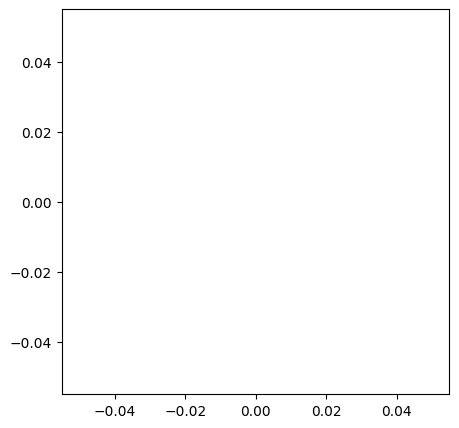

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12672
           1       0.16      0.13      0.14       127

    accuracy                           0.98     12799
   macro avg       0.57      0.56      0.57     12799
weighted avg       0.98      0.98      0.98     12799

MCC:  0.1321455057634252


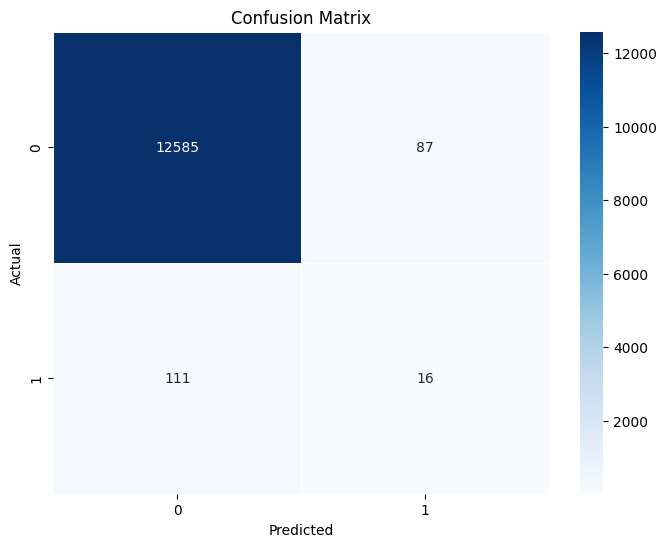

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
# import lightgbm
import datetime
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

current_date = datetime.datetime.now()
current_date= current_date.strftime("%Y-%m-%d") 

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx[:20]  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"All Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_1yr/{model_name}_feature_importances.png')
    plt.show()

    return top_sorted_features

def model_testing(train_df, test_df, classifier):
    seed = 42
    exclude_columns = ['fsym_id', 'label']
    
    train_df = train_df.set_index('date')
    test_df = test_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.sort_index()
    
    train_df2 = train_df[train_df.index < '2018-01-01']
    X_train2 = train_df2.drop(exclude_columns, axis=1)
    y_train2 = train_df2['label']
    
    val_df = train_df[(train_df.index >= '2018-01-01') & (train_df.index < '2020-01-01')]
    X_val = val_df.drop(exclude_columns, axis=1)
    y_val = val_df['label']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',10,1000,1),
                        'max_depth':hp.quniform('max_depth',5,600,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 5, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05),
                       'scale_pos_weight' : hp.uniform('scale_pos_weight', 100, 1000)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=seed)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=3)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        # classifier_instance.fit(X_train2, y_train2)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        # y_pred = classifier_instance.predict(X_val)
        # score = matthews_corrcoef(y_val, y_pred)
        # obj_scores.append(score)
        return -scores.mean()

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        # res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(15))
    print(f"Best params:{best_params}")
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    all_reports = []
    plt.figure(figsize=(5,5))
    plt.plot(obj_scores)
    plt.show()
    
    classifier_instance.fit(X_train, y_train)
    preds = classifier_instance.predict(X_test)
    final_report = classification_report(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    
    print(final_report)
    print("MCC: ", mcc)
    write_results(final_report, mcc, best_params, f'results_1yr/report_{classifier}')
    

    cm = confusion_matrix(y_test, preds, labels=classifier_instance.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    test_df_full = test_df.copy()
    test_df_full['preds'] = preds

    return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df_full


model, feats, X_train, X_test, test_df_with_preds = model_testing(train_df, test_df, 'XGB')

### Save/Load Model

In [93]:
pickle.dump(model, open(model_filename, "wb"))

In [96]:
model_filename = "results_1yr/xgboost_best.pkl"
import pickle




In [97]:
model_loaded = pickle.load(open(model_filename, "rb"))

In [98]:
def test_model(test_df, model):
    exclude_columns = ['fsym_id', 'label']
    test_df = test_df.set_index('date')
    test_df = test_df.sort_index()
    
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    preds = model.predict(X_test)
    final_report = classification_report(y_test, preds)
    print(final_report)
    mcc = matthews_corrcoef(y_test, preds)
    print(mcc)
    
    
test_model(test_df, model_loaded)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12672
           1       0.16      0.13      0.14       127

    accuracy                           0.98     12799
   macro avg       0.57      0.56      0.57     12799
weighted avg       0.98      0.98      0.98     12799

0.1321455057634252


## Feature Importances

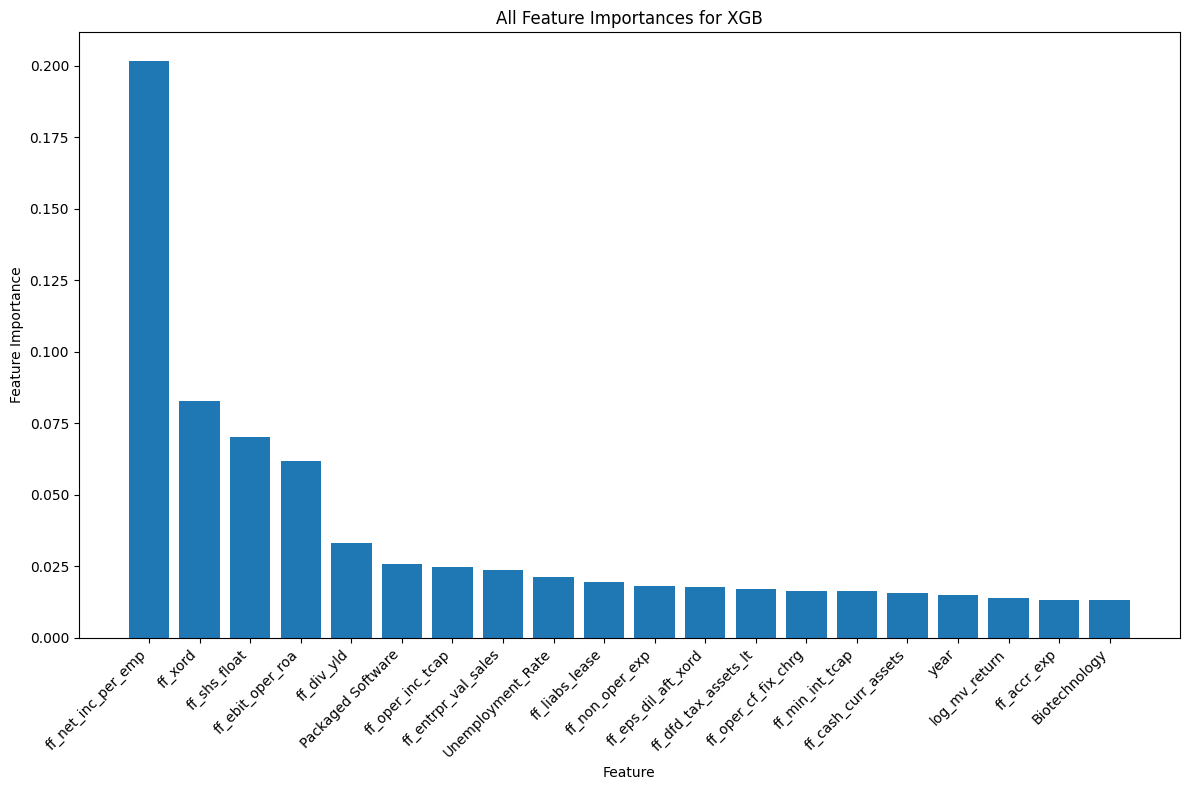

In [101]:
feats_to_drop = feature_importances(model_loaded,feats, 'XGB')
# train_df2 = train_df.drop(feats_to_drop, axis=1)
# test_df2 = test_df.drop(feats_to_drop, axis=1)
# model2, feats2, _,_,_ = model_testing(train_df2, test_df2, 'XGB')

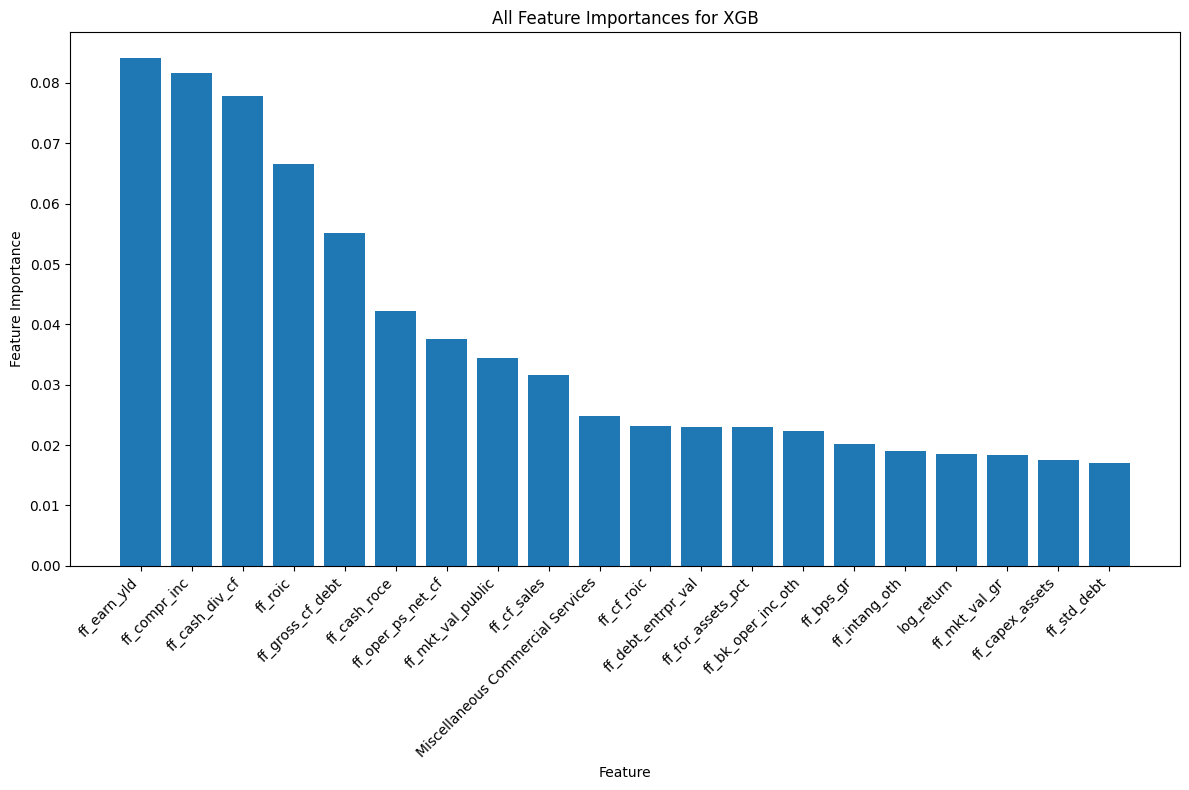

In [100]:
_ = feature_importances(model2,feats2,'XGB')

In [102]:
len(X_train.columns)

61

 98%|===================| 12547/12799 [00:40<00:00]        

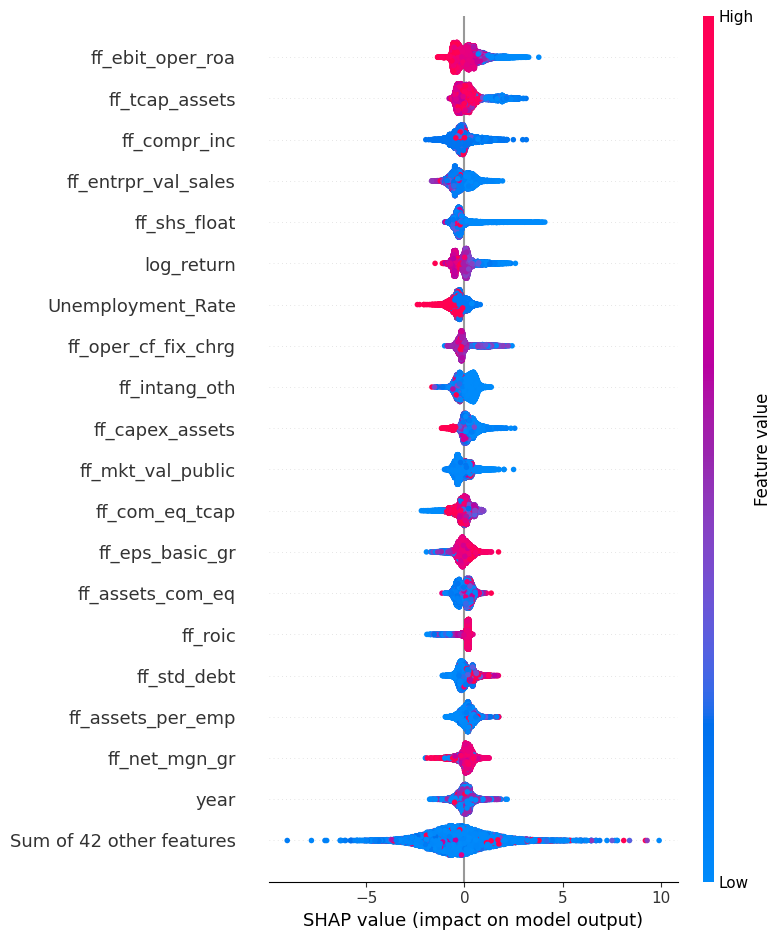

In [104]:
import shap


def shapley(model, train, test, model_name, plot_type):
    # train = train.toPandas()
    # test=test.toPandas()
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model,train)
    shap_values = explainer(test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.beeswarm(shap_values)
    # shap.summary_plot(shap_values,test,show=False)
    if plot_type == 'bar':
        shap.plots.bar(shap_values, max_display=20, show=False)
    elif plot_type == 'beeswarm':
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        
    plt.tight_layout()
    plt.savefig(f'results_1yr/{model_name}_shap_{plot_type}.png')
    
    
# shapley(model, train_df, test_df, model_name='rf')
    
shapley(model_loaded, X_train, X_test, 'XGB', 'beeswarm')

In [45]:
train_df.head()

,index,fsym_id,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_fix_assets,ff_cash_curr_assets,...,ff_std_debt,ff_bk_oper_inc_oth,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,48976,GJZ5YB-R,143.784000,1.729254,42.422,0.067783,40.774170,21.456759,38.323007,2.935040,...,16.327238,0.0,418.805,0.0,6.031711,47.160,258.142,0.011395,3.9,0
2000-01-31,87865,GSXP1N-R,6.019841,1.194269,0.000,0.184405,17.212545,2.732302,25.527204,70.773903,...,0.000000,0.0,0.000,0.0,-23.401890,0.000,14.350,0.011395,3.9,0
2000-01-31,70510,WPKF66-R,389.953000,2.733014,81.397,0.054461,4.659683,12.656485,33.016331,33.537477,...,51.517129,0.0,534.159,0.0,68.939663,0.018,570.000,0.011395,3.9,0
2000-01-31,89899,LWY6TY-R,6.947000,1.902163,1.656,0.276648,29.050884,6.648226,14.881759,14.276476,...,6.672323,0.0,0.000,0.0,5.554106,0.000,28.144,0.011395,3.9,0
2000-01-31,38583,BZNBHW-R,29.544000,2.373729,4.166,0.092724,-6.072055,5.046265,6.617032,3.564810,...,5.623622,0.0,0.000,0.0,7.655820,0.000,-7.665,0.011395,3.9,0


In [94]:
from sklearn.ensemble import IsolationForest

def anomaly_det(train_df, test_df):
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()
    exclude_columns = ['fsym_id', 'label', 'date']
    features = train_df.drop(exclude_columns, axis=1).columns
    print("Converted to Pandas")
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df.set_index('date', inplace=True)
    train_df.sort_index(inplace=True)
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df.set_index('date', inplace=True)
    test_df.sort_index(inplace=True)
    contam = len(train_df[train_df['label']==1])/len(train_df)
    isol_for = IsolationForest(contamination=contam, random_state=42)
    non_anomalies = train_df[train_df['label']==0]
    isol_for.fit(non_anomalies[features])
    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    cm = confusion_matrix(test_df['label'], test_df['preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
# anomaly_det(train_df, test_df)

## MLP Training

In [26]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.preprocessing import StandardScaler

# Define the search space for hyperparameters

def hyperopt_nn(train_df, test_df):
    train_df = train_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.set_index('date')
    test_df = test_df.sort_index()
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = train_df.drop(['fsym_id', 'label'], axis=1)
    X_val = test_df.drop(['fsym_id', 'label'], axis=1)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    y_train = train_df['label']
    y_val = test_df['label']
    
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        y_true = tf.cast(y_true, tf.float32)
      
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

        focal_loss = -alpha * (1 - p_t) ** gamma * ce_loss

        return tf.reduce_mean(focal_loss)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >= 0.5 else 0
            
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_1yr/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
    
# hyperopt_nn(train_df, test_df)

In [65]:
from CreateDataset import get_fund_data
import math
from datetime import datetime, timedelta

def plot_prices(imp_df, pic_name):
    imp_df=imp_df.sort_values(by=['fsym_id', 'date'])
    imp_df['date'] = pd.to_datetime(imp_df['date'])
    list_to_plot = sorted(imp_df['fsym_id'].unique().tolist())
    
    columns = 5
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = imp_df[imp_df['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        
        imp_start_date = temp_df['Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_start_date + timedelta(days=365)
        
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            # imp_start_date = pd.to_datetime(imp_start_date)
            # imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)


def plot_true_false_positives(test_df, square, model_name):
    if square == 'FP':
        df = test_df[(test_df['label'] == 0) & (test_df['preds'] == 1)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_positives_{model_name}.png')
    elif square == 'FN':
        df = test_df[(test_df['label'] == 1) & (test_df['preds'] == 0)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_negatives_{model_name}.png')
        

        

# plot_true_false_positives(test_df_with_preds, 'FN', 'XGB')

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-04-18 15:17:20,558 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-04-18 15:17:21,591 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-04-18 15:17:21,592 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2024-04-18 15:17:

# Scrap Code

In [ ]:
# import numpy as np

# def create_sequences_from_df(df, sequence_length, features, label_col):
#     sequences, targets = [], []
#     grouped = df.groupby('fsym_id')
#     for _, group in grouped:
#         stock_data = group[features + [label_col]].values
#         for i in range(len(stock_data) - sequence_length):
#             sequences.append(stock_data[i:i+sequence_length, :-1])  # Exclude label from input sequence
#             # print(stock_data[i+sequence_length, -1])
#             targets.append(stock_data[i+sequence_length, -1])  # Index -1 for the label column
#     return np.array(sequences), np.array(targets)

# # Example usage
# train_df = train_df.sort_values(by=['fsym_id','date'])
# test_df = test_df.sort_values(by=['fsym_id','date'])
# sequence_length = 1
# features_to_include = train_df.drop(['fsym_id', 'date', 'label'], axis=1).columns.tolist()
# label_column = 'label'

# input_sequences_train, targets_train = create_sequences_from_df(train_df, sequence_length, features_to_include, label_column)
# input_sequences_test, targets_test = create_sequences_from_df(test_df, sequence_length, features_to_include, label_column)

# # Reshape data for LSTM input
# input_sequences_train = np.reshape(input_sequences_train, (input_sequences_train.shape[0], sequence_length, len(features_to_include)))
# input_sequences_test = np.reshape(input_sequences_test, (input_sequences_test.shape[0], sequence_length, len(features_to_include)))

# # Now 'input_sequences_train' and 'targets_train', 'input_sequences_test', 'targets_test' are ready to be used for training and testing


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K

# Define MCC metric function
def matthews_correlation_coefficient(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# Define the LSTM model for binary classification
model = Sequential([
    LSTM(units=50, input_shape=(input_sequences_train.shape[1], input_sequences_train.shape[2])),
    Dense(units=1, activation='sigmoid')  # Binary classification output
])

# Compile the model with custom MCC metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[matthews_correlation_coefficient])

# Train the model
history = model.fit(input_sequences_train, targets_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
loss, mcc = model.evaluate(input_sequences_test, targets_test)
print(f'Test Loss: {loss}')
print(f'Test MCC: {mcc}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'model' is your trained model
# Assuming 'input_sequences_test' contains your test data and 'targets_test' contains corresponding true labels

# Make predictions on test data
predictions = model.predict(input_sequences_test)
# Apply threshold (e.g., 0.5 for binary classification)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(targets_test, binary_predictions)

# Print classification report
print(classification_report(targets_test, binary_predictions))

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    tscv = TimeSeriesSplit(n_splits=5)
    seed = 42
    df=df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]
    print(len(features))
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        print(num_pos/len(y_train))
        isol_for = IsolationForest(contamination=num_pos/len(y_train), random_state=42)

        isol_for.fit(x_train[features])

        train_df = x_train.copy()  # Create a copy of the training set for results
        test_df = x_test.copy()    # Create a copy of the test set for results

        train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
        train_df['anomaly'] = isol_for.predict(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

        test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
        test_df['anomaly'] = isol_for.predict(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)

        print(f"Classification Report: ")
        print(classification_report(y_test, test_df['preds']))
        # cm = confusion_matrix(y_test, test_df['preds'])
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
   

    
    
    
# anomaly_det(df2)

In [ ]:
def shapley(model, train, test):
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.initjs()
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    
shapley(model2, X_train2, None)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Generate some dummy time series data


# Define the number of folds for cross-validation

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':#
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
    
def plot_loss(history, label, n):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def nn_training(df):
    df=df.set_index('date')
    df=df.sort_index()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    seed = 42
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']

    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)
    }
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    
    def make_model(train_features, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
            
        model = keras.Sequential([
              keras.layers.Dense(
                  16, activation='relu',
                  input_shape=(train_features.shape[-1],)),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(1, activation='sigmoid',
                                 bias_initializer=output_bias),
          ])
   
        
        model.compile(
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=metrics)
        return model
    
    def get_preds(model, feats, truth):
        predictions = model.predict(feats, batch_size = 2048)
        print(predictions)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(classification_report(truth, predictions))
    
    
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
#         tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
#         tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date


    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    
    print(len(y_train), len(y_train[y_train==1]), len(y_test), len(y_test[y_test==1]))

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    pos = len(y_train[y_train==1])
    neg = len(y_train[y_train==0])
    print(pos/neg)
    initial_bias = np.log([pos/neg])

    model = make_model(X_train, output_bias=initial_bias)
    print(model.summary())

    fit_model = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data = (X_test, y_test), class_weight = class_weight_dict, 
                        
                         verbose=0)
    # plot_model_performance(fit_model, 'bin_cross_entropy', 'accuracy')
    plot_metrics(fit_model)
    # plot_loss(fit_model, "Train Loss", 0)

    results = model.evaluate(X_test, y_test)
    print(f'Test loss: {results[0]}')

    # Make predictions on new data
    get_preds(model, X_train, y_train)
    get_preds(model, X_test, y_test)
        

#     cm = confusion_matrix(y_test, predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#     plt.title(f'Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()


    
# nn_training(df)

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()